# AutoEncoder - using pre-trained image classifier in Encoder

In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
import sys

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
import skimage
from PIL import Image
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.util import crop, pad
from skimage.morphology import label
from skimage.color import rgb2gray, gray2rgb, rgb2lab, lab2rgb
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

from tensorflow.keras.models import Model, load_model,Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, UpSampling2D, RepeatVector, Reshape
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras import backend as K



## Using Kaggle dataset 

We will be using the part of the dataset which is avialiable on the kaggle for our model


## Installing Kaggle Library 

Installing the Kaggle library and authenticatng it with your kaggle account to download the required dataset

Link : https://www.kaggle.com/thedownhill/art-images-drawings-painting-sculpture-engraving


In [ ]:
#!pip install -q kaggle
#!mkdir ~/.kaggle
#!touch ~/.kaggle/kaggle.json

#api_token = {"username":"","key":""}

#import json

#with open('/root/.kaggle/kaggle.json', 'w') as file:
#    json.dump(api_token, file)

#!chmod 600 ~/.kaggle/kaggle.json
#!kaggle datasets download -d thedownhill/art-images-drawings-painting-sculpture-engraving

# Optionally, you may download the data from book site

In [ ]:
!wget --no-check-certificate -r 'https://drive.google.com/uc?export=download&id=1CKs7s_MZMuZFBXDchcL_AgmCxgPBTJXK' -O art-images-drawings-painting-sculpture-engraving.zip

will be placed in the single file you specified.

--2020-10-17 08:25:04--  https://drive.google.com/uc?export=download&id=1CKs7s_MZMuZFBXDchcL_AgmCxgPBTJXK
Resolving drive.google.com (drive.google.com)... 173.194.76.113, 173.194.76.100, 173.194.76.139, ...
Connecting to drive.google.com (drive.google.com)|173.194.76.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘art-images-drawings-painting-sculpture-engraving.zip’

art-images-drawings     [ <=>                ]   3.21K  --.-KB/s    in 0s      

2020-10-17 08:25:05 (36.8 MB/s) - ‘art-images-drawings-painting-sculpture-engraving.zip’ saved [3289]

Loading robots.txt; please ignore errors.
--2020-10-17 08:25:05--  https://drive.google.com/robots.txt
Reusing existing connection to drive.google.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘art-images-drawings-painting-sculpture-engraving.zip’

art-images-drawings     [ 

# Unzipping data

In [ ]:
!unzip art-images-drawings-painting-sculpture-engraving.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/dataset_updated/training_set/sculpture/i - 969.jpeg  
  inflating: dataset/dataset_updated/training_set/sculpture/i - 97.jpeg  
  inflating: dataset/dataset_updated/training_set/sculpture/i - 970.jpeg  
  inflating: dataset/dataset_updated/training_set/sculpture/i - 971.jpeg  
  inflating: dataset/dataset_updated/training_set/sculpture/i - 972.jpeg  
  inflating: dataset/dataset_updated/training_set/sculpture/i - 973.jpeg  
  inflating: dataset/dataset_updated/training_set/sculpture/i - 974.jpeg  
  inflating: dataset/dataset_updated/training_set/sculpture/i - 976.jpeg  
  inflating: dataset/dataset_updated/training_set/sculpture/i - 977.jpeg  
  inflating: dataset/dataset_updated/training_set/sculpture/i - 978.jpeg  
  inflating: dataset/dataset_updated/training_set/sculpture/i - 979.jpeg  
  inflating: dataset/dataset_updated/training_set/sculpture/i - 98.jpeg  
  inflating: dataset/dataset_updated/training_set/s

# Reading data

The dataset I am using is ~2000 classic paintings which we will remove the color from and attempt to teach a nearal network to recolorize them.

In [ ]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
TRAIN_PATH = '/content/dataset/dataset_updated/training_set/painting/'
train_ids = next(os.walk(TRAIN_PATH))[2]

# Counting bad images

In [ ]:
missing_count = 0
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_+''
    try:
        img = imread(path)
    except:
        missing_count += 1

print("\n\nTotal missing: "+ str(missing_count))

100%|██████████| 2128/2128 [00:05<00:00, 361.67it/s]



Total missing: 86


# Creating training set
Remove all bad images from the set

In [ ]:
X_train = np.zeros((len(train_ids)-missing_count, IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
missing_images = 0
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_+''
    try:
        img = imread(path)
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_train[n-missing_images] = img
    except:
        missing_images += 1

X_train = X_train.astype('float32') / 255.

100%|██████████| 2128/2128 [00:37<00:00, 56.92it/s]


# Displaying sample

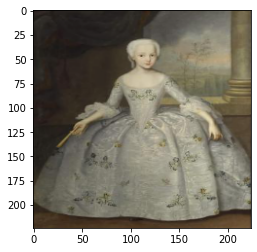

In [ ]:
plt.imshow(X_train[5])

# Creating Training/Testing datasets

In [ ]:
x_train, x_test = train_test_split(X_train, test_size=1500)

# Preprocessing Training dataset

In [ ]:
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)


In [ ]:
def image_a_b_gen(dataset=X_train):
    # iteration for every image
    for batch in datagen.flow(dataset, batch_size=542):
        # convert from rgb to grayscale
        X_batch = rgb2gray(batch)                              
        # convert the rgb to Lab format
        lab_batch = rgb2lab(batch)

        X_batch = lab_batch[:,:,:,1:] /128

        return X_batch

# Creating VGG Model

In [ ]:
vggmodel = tf.keras.applications.vgg16.VGG16()
newmodel = Sequential() 
num = 0
for i, layer in enumerate(vggmodel.layers):
    if i<19:
      newmodel.add(layer)
newmodel.summary()
for layer in newmodel.layers:
  layer.trainable=False

553467904/553467096 [==============================] - 14s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
______________________________________________________

# Extracting features

Extract image features using VGG16 model

In [ ]:
vggfeatures = []
for sample in x_train:
  sample = gray2rgb(sample)
  sample = sample.reshape((1,224,224,3))
  prediction = newmodel.predict(sample)
  prediction = prediction.reshape((7,7,512))
  vggfeatures.append(prediction)
vggfeatures = np.array(vggfeatures)

## MAking the Encoder/Decoder model

In [ ]:
#Encoder
encoder_input = Input(shape=(7, 7, 512,))
#Decoder
decoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_input)
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
model = Model(inputs=encoder_input, outputs=decoder_output)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 7, 7, 512)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 7, 7, 256)         1179904   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         295040    
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        73792     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)       

# Model training

In [ ]:
model.compile(optimizer='Adam', loss='mse')
model.fit(vggfeatures, image_a_b_gen(x_train), verbose=1, epochs=100, batch_size=128)

Epoch 1/100
5/5 [==============================] - 1s 146ms/step - loss: 0.2282
Epoch 2/100
5/5 [==============================] - 0s 91ms/step - loss: 0.0113
Epoch 3/100
5/5 [==============================] - 0s 89ms/step - loss: 0.0090
Epoch 4/100
5/5 [==============================] - 0s 87ms/step - loss: 0.0079
Epoch 5/100
5/5 [==============================] - 0s 94ms/step - loss: 0.0071
Epoch 6/100
5/5 [==============================] - 0s 85ms/step - loss: 0.0068
Epoch 7/100
5/5 [==============================] - 0s 88ms/step - loss: 0.0066
Epoch 8/100
5/5 [==============================] - 0s 90ms/step - loss: 0.0065
Epoch 9/100
5/5 [==============================] - 0s 90ms/step - loss: 0.0064
Epoch 10/100
5/5 [==============================] - 0s 85ms/step - loss: 0.0063
Epoch 11/100
5/5 [==============================] - 0s 86ms/step - loss: 0.0063
Epoch 12/100
5/5 [==============================] - 0s 85ms/step - loss: 0.0063
Epoch 13/100
5/5 [==============================

# Model Testing

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 24416 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


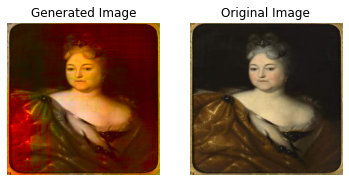

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 35398 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


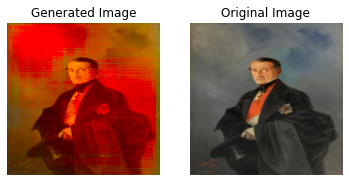

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 40541 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


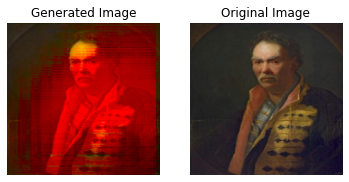

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 21834 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


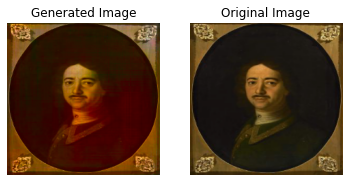

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 7485 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


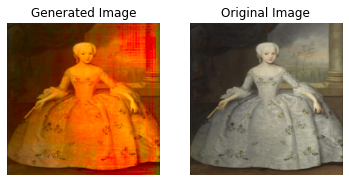

In [ ]:
sample = x_test[1:6]
for image in sample:
  lab = rgb2lab(image)
  l = lab[:,:,0]
  L = gray2rgb(l)
  L = L.reshape((1,224,224,3))
  vggpred = newmodel.predict(L)
  ab = model.predict(vggpred)
  ab = ab*128
  cur = np.zeros((224, 224, 3))
  cur[:,:,0] = l
  cur[:,:,1:] = ab
  plt.subplot(1,2,1)
  plt.title("Generated Image")
  plt.imshow( lab2rgb(cur))
  plt.axis('off')
  plt.subplot(1,2,2)
  plt.title("Original Image")
  plt.imshow(image)
  plt.axis('off')
  plt.show()

## Testing on unseen data

In [ ]:
!wget https://raw.githubusercontent.com/Apress/artificial-neural-networks-with-tensorflow-2/main/ch14/mountain.jpg

--2020-10-17 08:28:46--  https://raw.githubusercontent.com/Apress/artificial-neural-networks-with-tensorflow-2/main/ch14/mountain.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180557 (176K) [image/jpeg]
Saving to: ‘mountain.jpg’

mountain.jpg        100%[===================>] 176.33K  --.-KB/s    in 0.02s   

2020-10-17 08:28:46 (10.3 MB/s) - ‘mountain.jpg’ saved [180557/180557]



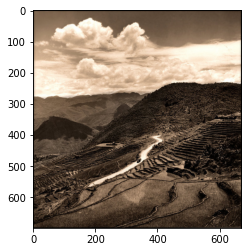

In [ ]:
img = imread("mountain.jpg")
plt.imshow(img)

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 2845 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(-0.5, 223.5, 223.5, -0.5)

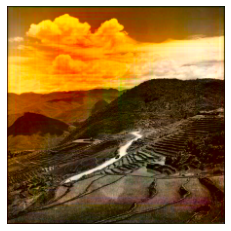

In [ ]:
test = img_to_array(load_img("mountain.jpg"))
test = resize(test, (224,224), anti_aliasing=True)
test*= 1.0/255
lab = rgb2lab(test)
l = lab[:,:,0]
L = gray2rgb(l)
L = L.reshape((1,224,224,3))
vggpred = newmodel.predict(L)
ab = model.predict(vggpred)
ab = ab*128
cur = np.zeros((224, 224, 3))
cur[:,:,0] = l
cur[:,:,1:] = ab
plt.imshow( lab2rgb(cur))
plt.axis('off')